## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split

from random import sample 

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
PNEUMONIA_TAG = 'pneumonia'
NO_PNEUMONIA_TAG = 'no_pneumonia'

In [3]:
def load_dataframe(filename):
    dataframe = pd.read_csv(filename)
    all_image_paths = {os.path.basename(x): x for x in 
                       glob(os.path.join('/data','images*', '*', '*.png'))}
    print('Scans found:', len(all_image_paths), ', Total Headers', dataframe.shape[0])
    dataframe['path'] = dataframe['Image Index'].map(all_image_paths.get)
    
    ## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
    ## rather than working directly with the 'Finding Labels' column
    all_labels = np.unique(list(chain(*dataframe['Finding Labels'].map(lambda finding: finding.split('|')).tolist())))
    all_labels = [label for label in all_labels if len(label) > 0]

    for label in all_labels:
        dataframe[label] = dataframe['Finding Labels'].map(lambda finding: 1 if label in finding else 0)

    dataframe['pneumonia_class'] = dataframe['Pneumonia'].replace(1, PNEUMONIA_TAG).replace(0, NO_PNEUMONIA_TAG)

    return dataframe, all_labels

In [4]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_xray_df, all_labels = load_dataframe('/data/Data_Entry_2017.csv')
all_xray_df.head()

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,no_pneumonia
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,0,0,0,no_pneumonia
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,no_pneumonia
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,1,0,0,0,0,no_pneumonia
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,1,0,0,0,0,0,0,0,no_pneumonia


## Create your training and testing data:

### We will
- Split the data into train(80%) and validation(20%) based on the pneumonia_class.
- Correct the balance of the train to 50 postive and 50 negative cases.
- Correct the balance in the validation set based on the presence pneumonia with a 80-20 split.

In [6]:
def create_splits(dataframe):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # 1. Split data into train and validation sets 80%-20%
    train_data, valid_data = train_test_split(dataframe,
                                              test_size = 0.2,
                                              stratify = dataframe['pneumonia_class'])
    
    # 2. Correct the balance of the train_data to 50-50
    pneumonia_idx = train_data[train_data.pneumonia_class == PNEUMONIA_TAG].index.tolist()
    no_pneumonia_idx = train_data[train_data.pneumonia_class == NO_PNEUMONIA_TAG].index.tolist()
    
    no_pneumonia_sample_idx = sample(no_pneumonia_idx, len(pneumonia_idx))
    train_data = train_data.loc[pneumonia_idx + no_pneumonia_sample_idx]
    
    # 3. Correct the balance in the validation set to 80-20
    pneumonia_idx = valid_data[valid_data.pneumonia_class == PNEUMONIA_TAG].index.tolist()
    no_pneumonia_idx = valid_data[valid_data.pneumonia_class == NO_PNEUMONIA_TAG].index.tolist()
    
    no_pneumonia_sample_idx = sample(no_pneumonia_idx, 4 * len(pneumonia_idx))
    valid_data = valid_data.loc[pneumonia_idx + no_pneumonia_sample_idx]
    
    return train_data, valid_data

In [7]:
train_df, valid_df = create_splits(all_xray_df)
print(train_df.shape, valid_df.shape)

(2290, 29) (1430, 29)


[Text(0, 0.5, 'Number of Images with Label')]

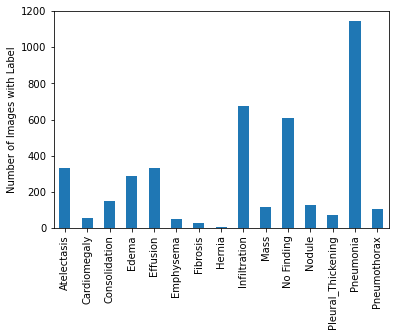

In [8]:
ax = train_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

[Text(0, 0.5, 'Number of Images with Label')]

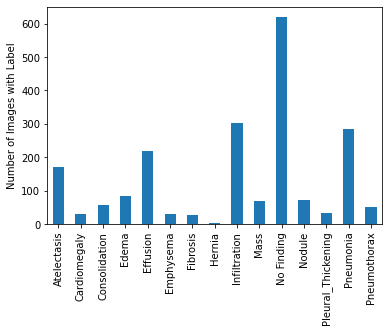

In [9]:
ax = valid_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [12]:
IMG_SIZE = (224,224)

In [16]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    my_idg = ImageDataGenerator(
        rescale = 1. / 255.0,
        horizontal_flip = True,
        vertical_flip = False,
        height_shift_range = 0.1,
        width_shift_range = 0.1,
        rotation_range = 20,
        shear_range = 0.1,
        zoom_range = 0.1)
    
    return my_idg


def make_train_gen(vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_idg = my_image_augmentation()
    train_gen = train_idg.flow_from_dataframe(dataframe=vargs, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 64
                                         )

    return train_gen


def make_val_gen(vargs):
    # Note that the validation data should not be augmented! 
    # We only want to do some basic intensity rescaling here
    val_idg = ImageDataGenerator(rescale=1. / 255.0)
    val_gen = val_idg.flow_from_dataframe(dataframe = vargs, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = IMG_SIZE, 
                                             batch_size = 128) 
    return val_gen

def make_test_gen(df, batch_size):
    # Note that the validation data should not be augmented! 
    # We only want to do some basic intensity rescaling here
    test_idg = ImageDataGenerator(rescale=1. / 255.0)
    test_gen = test_idg.flow_from_dataframe(dataframe = df, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = IMG_SIZE, 
                                             batch_size = batch_size) 
    return test_gen

In [17]:
train_gen = make_train_gen(train_df)
val_gen = make_val_gen(valid_df)
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


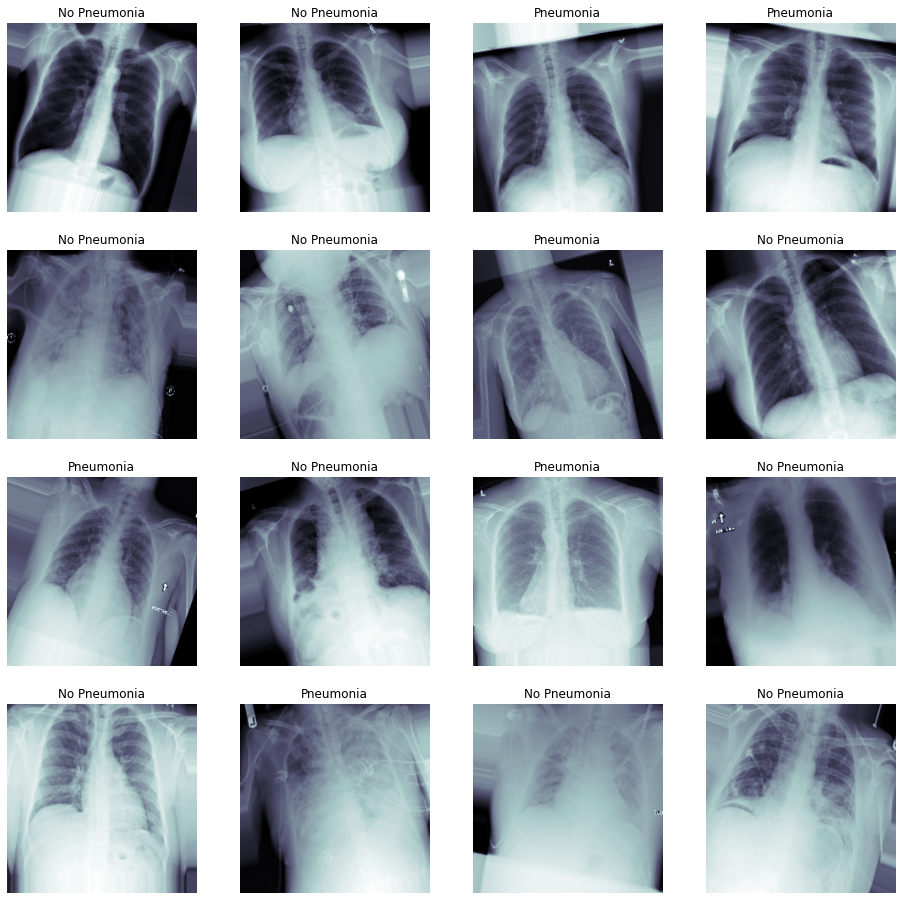

In [18]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [19]:
def load_pretrained_model(lay_of_interest):
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    return vgg_model

In [25]:
def build_my_model(model):
    
    ## Set our optimizer, loss function, and learning rate
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    my_model = Sequential()
    my_model.add(model)
    
    # Flatten the ouput as it is from a convolutional layer
    my_model.add(Flatten())
    
    # Add a FC layer
    my_model.add(Dense(1024, activation = 'relu'))
    my_model.add(Dropout(0.2))

    my_model.add(Dense(512, activation = 'relu'))
    my_model.add(Dropout(0.2))
    
    my_model.add(Dense(256, activation = 'relu'))
    my_model.add(Dropout(0.2))
    
    # Last layer
    my_model.add(Dense(1, activation = 'sigmoid'))
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [26]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')
METRIC_TO_MONITOR = 'val_loss'
MODE = 'min'
checkpoint = ModelCheckpoint(weight_path, 
                             monitor= METRIC_TO_MONITOR, 
                             verbose=1, 
                             save_best_only=True, 
                             mode= MODE, 
                             save_weights_only = True)

early = EarlyStopping(monitor= METRIC_TO_MONITOR, 
                      mode= MODE, 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [27]:
lay_of_interest = 'block5_pool'
vgg_model = load_pretrained_model(lay_of_interest)
vgg_model.summary()

# We will freeze all but the fifth block
size = len(vgg_model.layers)
for layer in vgg_model.layers[:size - 4]:
    layer.trainable = False

# Print the layers to check everything is fine
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [28]:
## train your model
my_model = build_my_model(vgg_model)
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 15, 
                          callbacks = callbacks_list)

Epoch 1/15
36/36 [==============================] - 61s 2s/step - loss: 0.7089 - binary_accuracy: 0.5157 - val_loss: 0.6012 - val_binary_accuracy: 0.7500

Epoch 00001: val_loss improved from inf to 0.60117, saving model to xray_class_my_model.best.hdf5
Epoch 2/15
36/36 [==============================] - 60s 2s/step - loss: 0.6732 - binary_accuracy: 0.5773 - val_loss: 0.7120 - val_binary_accuracy: 0.5547

Epoch 00002: val_loss did not improve from 0.60117
Epoch 3/15
36/36 [==============================] - 59s 2s/step - loss: 0.6741 - binary_accuracy: 0.5869 - val_loss: 0.5237 - val_binary_accuracy: 0.8125

Epoch 00003: val_loss improved from 0.60117 to 0.52373, saving model to xray_class_my_model.best.hdf5
Epoch 4/15
36/36 [==============================] - 61s 2s/step - loss: 0.6612 - binary_accuracy: 0.6000 - val_loss: 0.6443 - val_binary_accuracy: 0.7109

Epoch 00004: val_loss did not improve from 0.52373
Epoch 5/15
36/36 [==============================] - 60s 2s/step - loss: 0.6479

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [48]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.

my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

128/128 [==============================] - 1s 9ms/step


In [49]:
def plot_auc(t_y, p_y):
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    fig, c_ax = plt.subplots(1,1, figsize = (9,9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)' % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')


## what other performance statistics do you want to include here besides AUC? 

def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9,9))
    precision, recall, tresholds = precision_recall_curve(t_y, p_y)
    
    c_ax.plot(recall, precision, label = '%s (AP score:%0.2f)' % ('Pneumonia', average_precision_score(t_y, p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    return precision, recall, tresholds
    
# function to calculate the F1 score
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)
    
#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

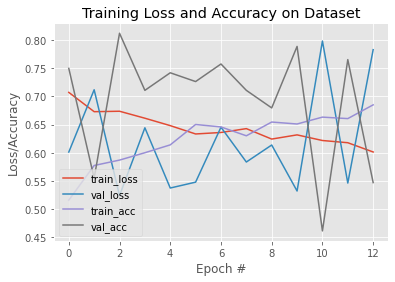

In [50]:
## plot figures
plot_history(history)

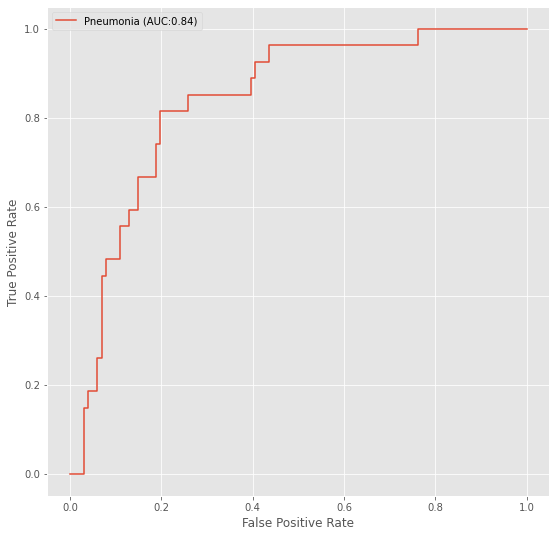

In [51]:
## plot Area Under the Curve (AUC)
plot_auc(valY, pred_Y)

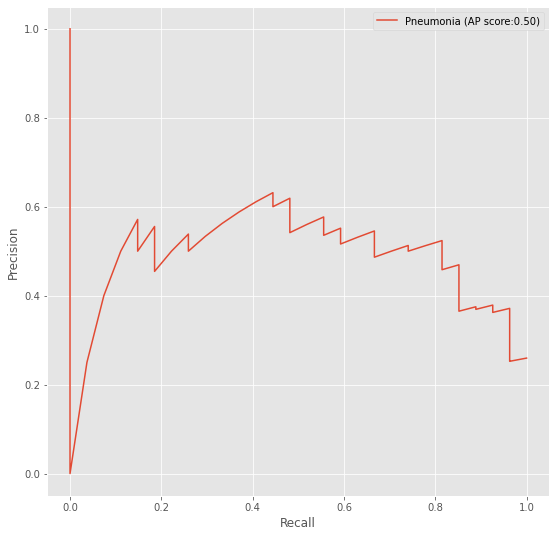

In [52]:
## plot precision recall curve
precision, recall, tresholds = plot_precision_recall_curve(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [53]:
def treshold_recall(recall_value):
    recalls = np.abs(recall - recall_value)
    idx = recalls.argmin()
    print('Precision is: ' + str(precision[idx]))
    print('Recall is: ' + str(recall[idx]))
    print('Treshold is: ' + str(tresholds[idx]))
    print('F1 Score is: ' + str(calc_f1(precision[idx], recall[idx])))
    print('\n')

In [54]:
treshold_recall(0.7)

Precision is: 0.5
Recall is: 0.7037037037037037
Treshold is: 0.46238473
F1 Score is: 0.5846153846153846




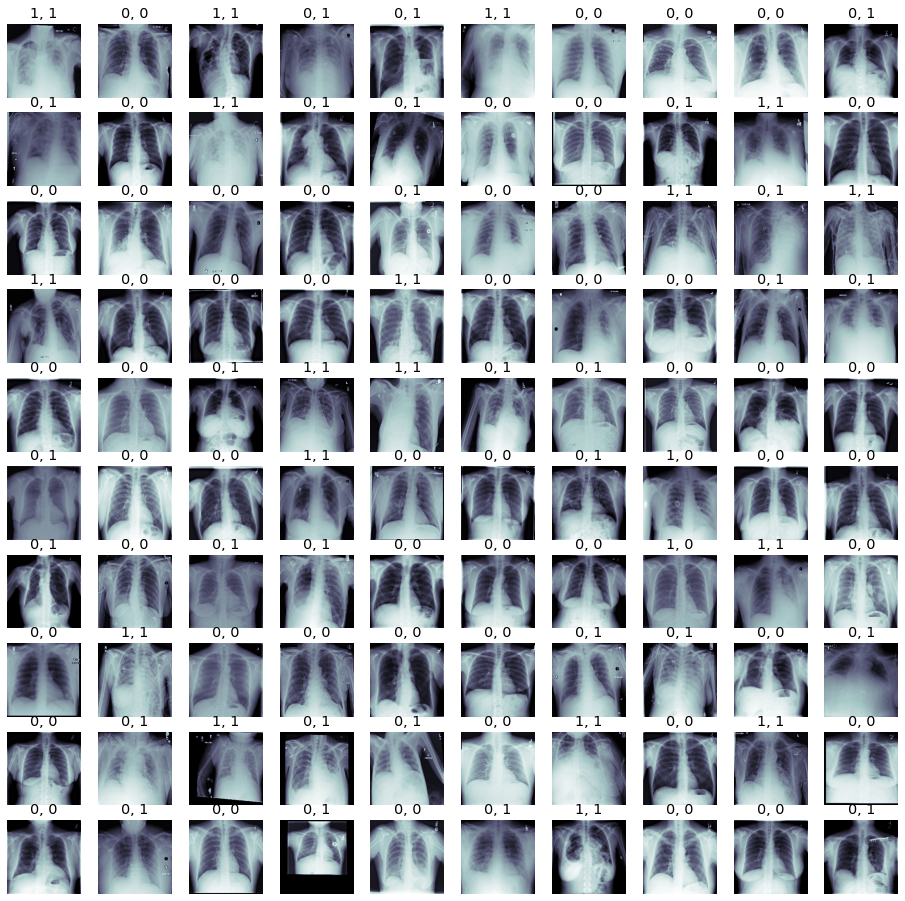

In [47]:
## Let's look at some examples of true vs. predicted with our best model: 
THRESHOLD = 0.4
# Todo
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [94]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)